In [1]:
import pandas as pd

In [2]:
df_21= pd.read_csv('data21.csv')

In [3]:
df_21

,and_ones,assist_percentage,assists,assists_per_poss,block_percentage,blocking_fouls,blocks,blocks_per_poss,box_plus_minus,center_percentage,...,two_pointers,two_pointers_per_poss,two_pointers_assisted_percentage,usage_percentage,value_over_replacement_player,weight,win_shares,win_shares_per_48_minutes,name,team
0,NaN,12.7,2.0,5.2,0.0,NaN,0.0,0.0,-19.8,0,...,1.0,2.6,NaN,18.6,-0.1,225,-0.1,-0.252,Jaylen Adams,MIL
1,NaN,28.7,357.0,8.3,3.2,NaN,73.0,1.7,9.0,0,...,559.0,13.0,NaN,32.5,5.6,242,10.2,0.244,Giannis Antetokounmpo,MIL
2,NaN,10.3,46.0,3.9,1.6,NaN,10.0,0.9,-3.5,0,...,60.0,5.1,NaN,15.3,-0.2,219,0.7,0.057,Thanasis Antetokounmpo,MIL
3,NaN,22.2,188.0,7.8,0.1,NaN,1.0,0.0,-2.1,0,...,52.0,2.2,NaN,16.8,0.0,183,2.1,0.088,D.J. Augustin,MIL
4,NaN,12.6,3.0,4.4,2.8,NaN,1.0,1.5,-7.3,0,...,5.0,7.3,NaN,24.0,0.0,210,0.0,0.008,Elijah Bryant,MIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,NaN,6.5,4.0,2.2,5.2,NaN,5.0,2.8,-5.3,0,...,7.0,3.9,NaN,17.6,-0.1,215,0.0,0.015,Alen Smailagić,GSW
622,NaN,18.1,150.0,6.4,2.1,NaN,26.0,1.1,0.8,0,...,84.0,3.6,NaN,11.0,0.8,209,3.0,0.130,Juan Toscano-Anderson,GSW
623,NaN,22.5,174.0,7.9,1.0,NaN,11.0,0.5,-4.0,0,...,99.0,4.5,NaN,16.9,-0.5,210,0.9,0.039,Brad Wanamaker,GSW
624,NaN,10.9,167.0,3.3,2.6,NaN,70.0,1.4,-0.4,0,...,365.0,7.3,NaN,23.3,1.0,197,3.9,0.080,Andrew Wiggins,GSW


In [4]:
df_21.plot.scatter(x='points', y='salary', title='salary depending on points')
df_21.plot.scatter(x='assists_per_poss', y='salary', title='salary depending on assists')
df_21.plot.scatter(x='win_shares', y='salary', title='salary depending on win_shares')
df_21.plot.scatter(x='player_efficiency_rating', y='salary', title='salary depending on player_efficiency_rating')

In [5]:
df_21[df_21['games_played']>=20].shape

(516, 108)

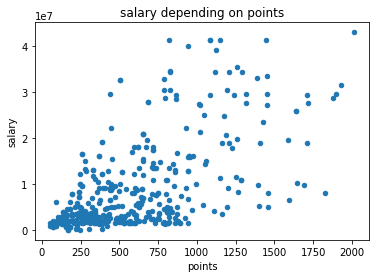

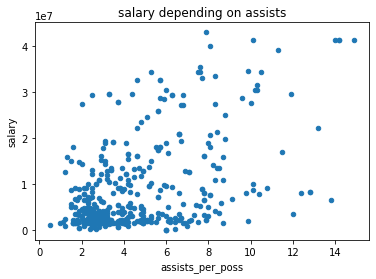

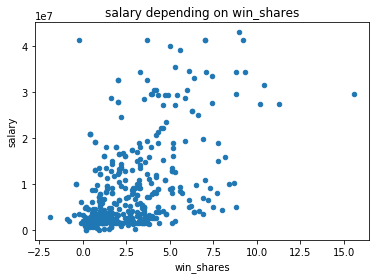

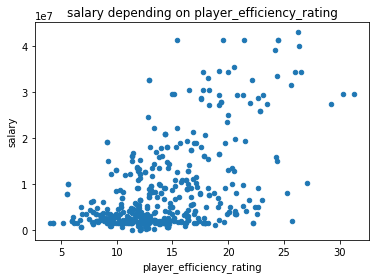

In [6]:
df_21[df_21['games_played']>=30].plot.scatter(x='points', y='salary', title='salary depending on points')
df_21[df_21['games_played']>=30].plot.scatter(x='assists_per_poss', y='salary', title='salary depending on assists')
df_21[df_21['games_played']>=30].plot.scatter(x='win_shares', y='salary', title='salary depending on win_shares')
df_21[df_21['games_played']>=30].plot.scatter(x='player_efficiency_rating', y='salary', title='salary depending on player_efficiency_rating')

In [7]:
import numpy as np

In [8]:
# Machine Learning with Scikit Learn

In [9]:
# Creation of X (feature Matrix)

In [10]:
x = df_21[df_21['games_played']>=20][['points','assists_per_poss','win_shares','player_efficiency_rating']]
x.dropna()
x=x.reset_index()
x=x.drop('index',axis=1)
x

,points,assists_per_poss,win_shares,player_efficiency_rating
0,1717.0,8.3,10.2,29.2
1,166.0,3.9,0.7,10.3
2,438.0,7.8,2.1,12.1
3,468.0,2.4,3.5,11.3
4,274.0,3.0,2.2,14.2
...,...,...,...,...
511,612.0,4.7,1.9,15.1
512,301.0,6.4,3.0,12.6
513,336.0,7.9,0.9,9.5
514,1320.0,3.3,3.9,15.0


In [11]:
np.any(np.isnan(x))

False

In [12]:
np.all(np.isfinite(x))

True

In [13]:
#Creation of Y (target)

In [14]:
y = df_21[df_21['games_played']>=20]['salary']
y

1      27528088.0
2       1701593.0
3       6666667.0
5       4938273.0
6       1678854.0
          ...    
620     2063280.0
622      358295.0
623     2250000.0
624    29542010.0
625     8730240.0
Name: salary, Length: 516, dtype: float64

In [15]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [16]:
# linear regression model
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(x_train, y_train)
Lasso(alpha=0.1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').